In [105]:
import numpy as np
import matplotlib.pyplot as plt

# Define the size of the field
size = 100

# Create an empty field
field = np.zeros((size, size))

# Define the center and radius of the circle
center = (size // 2, size // 2)
radius = size // 4

# Fill in the circle
for x in range(size):
    for y in range(size):
        if (x - center[0])**2 + (y - center[1])**2 <= radius**2:
            field[x, y] = 1


In [106]:

import numpy as np
from numpy.fft import fft2, ifft2, fftshift

def gaussian_kernel(size, sigma):
    """Generate a 2D Gaussian kernel."""
    hsize = int(size) // 2
    x, y = np.mgrid[-hsize:size - hsize, -hsize:size - hsize]
    normal = 1 / (2.0 * np.pi * sigma**2)
    g = np.exp(-((x**2 + y**2) / (2.0*sigma**2))) * normal
    g = np.roll(g, shift=(-hsize, -hsize), axis=(0, 1))
    return g

def apply_kernel(matrix, kernel):
    """Apply a kernel to a 2D matrix using the Fourier method."""
    # Compute the Fourier transforms of the input and the kernel
    matrix_ft = fft2(matrix)
    kernel_ft = fft2(kernel)

    # Multiply the Fourier transforms
    result_ft = matrix_ft * kernel_ft

    # Compute the inverse Fourier transform of the result
    result = np.real(ifft2(result_ft))

    return result

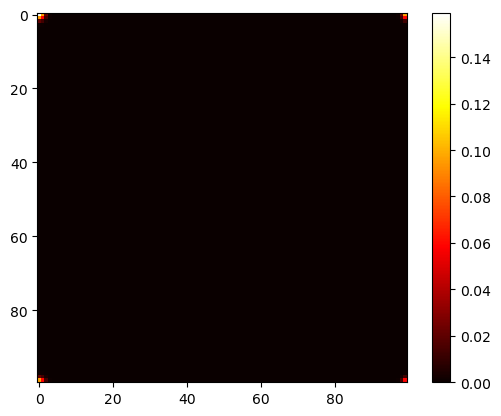

In [107]:

# Generate a Gaussian kernel
sigma = 1  # Standard deviation for Gaussian kernel
kernel_size = field.shape[0]  # Size of the Gaussian kernel
kernel = gaussian_kernel(kernel_size, sigma)

# Apply the Gaussian kernel
smoothed_field = apply_kernel(field, kernel)

# Plot the smoothed field
plt.imshow(kernel, cmap='hot', interpolation='nearest')
# plt.imshow(smoothed_field, cmap='hot', interpolation='nearest')
plt.colorbar()
plt.show()

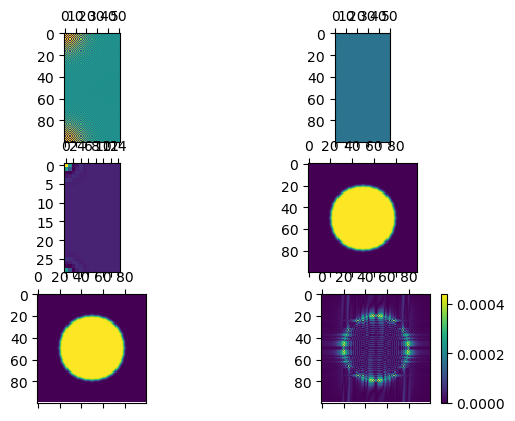

In [27]:
import numpy as np
import matplotlib.pyplot as plt

# Load the matrix from the text file
matrixa = np.loadtxt('build/in_a.txt')
matrixb = np.loadtxt('build/out_b.txt')
fk = np.loadtxt('build/out_a.txt')
convolved = np.loadtxt('build/convolved.txt')
smootheda = np.loadtxt('build/smoothed_a.txt')
smoothedb = np.loadtxt('build/smoothed_b.txt')

# Create a figure and a set of subplots
fig, axs = plt.subplots(3, 2)

# Display the matrix
cax = axs[0][0].matshow(matrixa, cmap='viridis')
cax2 = axs[0][1].matshow(matrixb, cmap='viridis')
cax3 = axs[1][0].matshow(fk, cmap='viridis')
cax4 = axs[1][1].matshow(convolved, cmap='viridis')
cax5 = axs[2][0].matshow(smoothedb, cmap='viridis')
cax6 = axs[2][1].matshow(abs(smoothedb / (smoothedb.shape[0] * smoothedb.shape[1]) - convolved), cmap='viridis')

# Add a colorbar to the plot
fig.colorbar(cax6)

# Show the plot
plt.show()

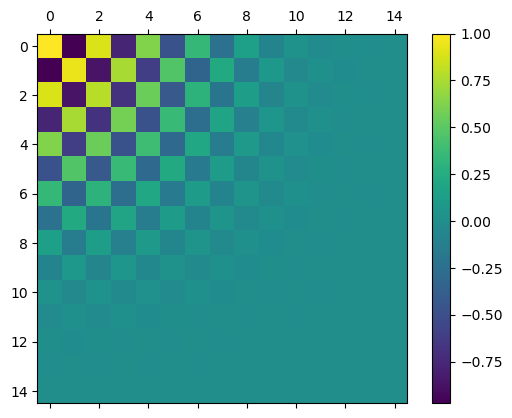

In [36]:
fig, axs = plt.subplots()
mat = np.loadtxt('build/r2r.txt')
cax = axs.matshow(mat[:, 0:mat.shape[0]], cmap='viridis')
fig.colorbar(cax)
plt.show()

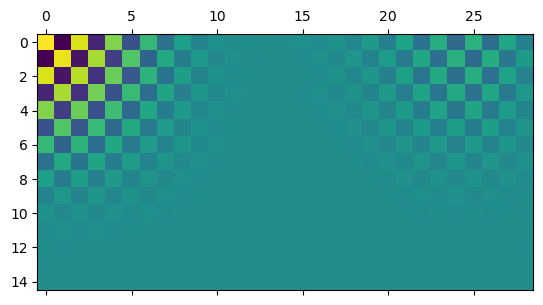

In [13]:
import numpy as np
import matplotlib.pyplot as plt

# Load the matrix from the text file
matrixa = np.loadtxt('build/in_a.txt')
matrixb = np.loadtxt('build/r2r.txt')
fk = np.loadtxt('build/out_a.txt')
convolved = np.loadtxt('build/convolved.txt')
smootheda = np.loadtxt('build/smoothed_a.txt')
smoothedb = np.loadtxt('build/smoothed_b.txt')

# Create a figure and a set of subplots
fig, axs = plt.subplots()

# Display the matrix
cax = axs.matshow(matrixb, cmap='viridis')


# Show the plot
plt.show()

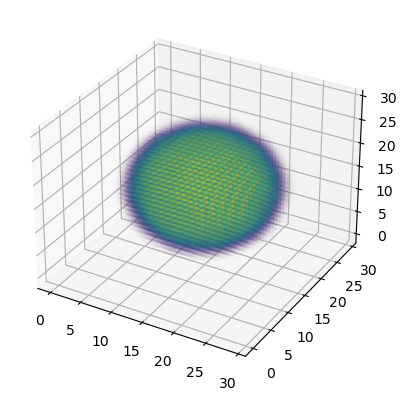

In [194]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Load the data from the file
data = np.loadtxt('build/convolved.txt')
data = data.reshape((data.shape[0], data.shape[0], data.shape[1] // data.shape[0]))

# Create a 3D plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Get the dimensions of the data
x_dim, y_dim, z_dim = data.shape

# Create a grid of coordinates
x, y, z = np.meshgrid(np.arange(x_dim), np.arange(y_dim), np.arange(z_dim))

# Create a colormap that goes from transparent to opaque
cmap = plt.cm.viridis
cmap._init()
alphas = np.linspace(0, 1, cmap.N+3)
cmap._lut[:,-1] = alphas

# Plot the data
sc = ax.scatter(x, y, z, c=data.flatten(), cmap=cmap)

# Show the plot
plt.show()

# How does the convolution work with FFTW

## The `r2r` vs the `r2c` Fourier transform

The `r2c` transform will take a real space field and map it to the "half-complex" plane. That means that the $x$-interval is halved. This is what it looks like 
if you are only looking at the real values:

![r2c](demo/r2c.png)

This is supposed to be more efficient because:
1. You are able to do an in-place transform and keep the same amount of memory (the amount of memory used for this field for complex values is the
same as the amount of memory used by real values).
2. You can more efficiently multiply it (or do other operations) because the field is now half the size.

On the other hand, there is also the `r2r` transform, which is actually somewhat similar, except for the fact that it places the
result in half-complex arrangement for each dimension. This is what the direct result of the `r2r` is:

![r2c](demo/r2r.png)

Notice that this is a quarter of the above. This is because are using `RTHC` for each dimension, which results in something even smaller than `r2c`. 


## Generating a kernel in real space

A kernel in real space is generated by populating the field directly by values of the Gaussian function:

```cpp
Eigen::MatrixXd m = Eigen::MatrixXd::Zero(size, size);
int center = size / 2;

for (int i = 0; i < size; ++i) {
  for (int j = 0; j < size; ++j) {
    int x = i - center;
    int y = j - center;
    if (x * x + y * y <= radius * radius) {
      m(i, j) = 1;
    }
  }
}
```

This is trivially extended to higher dimensions.

## Generating a kernel in Fourier space

It is possible to compute the transform with `r2r` or `r2c` (in the case of `r2r` the appropriate rearrangement must be made), and then
compute the kernel in Fourier space that way. On the other hand, an almost equivalant way of getting the kernel in Fourier space is directly
determining the values:

```cpp
size = 100;
hsize = size / 2;
for (int j = 0; j < size; ++j) {
  for (int i = 0; i < hsize; ++i) {
    double dx = 2 * pi / (size);
    double dy = 2 * pi / (size);
    double sigma = 1.0;  // Standard deviation of the Gaussian

    auto kx = ((i < size / 2) ? i * dx : (i - size) * dx);
    auto ky = ((j < size / 2) ? j * dy : (j - size) * dy);
    auto kk = kx * kx + ky * ky;

    double g = std::exp((kk / (2.0 * sigma * sigma)));

    kernel_fourier[i + j * hsize] = g;  // Real part
  }
}
```

The difference in applying the smoothing of these two methods is very small in the case of even-sized domains, but not
so in the case of odd-sized domains. However, it is still sufficient to generate the kernel using the above method.

Here is the difference for even dimension:

![diff](demo/r2c_k_diff.png)

